In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from pdefind import *
from PDE_Equation import pde_matrix_mul, sparse_coeff, normalized_xi_threshold, pde_Recover



u shape (256, 101)
x shape (256,)
t shape (101,)


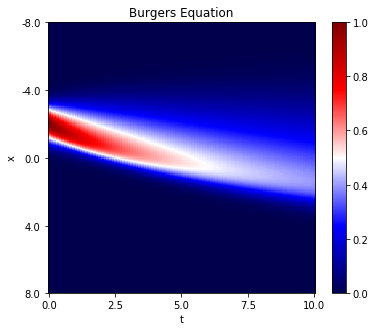

In [2]:
data = sio.loadmat(os.path.join(os.getcwd(), "data", "burgers.mat"))
u = data["usol"]
x = data["x"][0]
t = np.squeeze(data["t"], axis=1)

print("u shape", u.shape)
print("x shape", x.shape)
print("t shape", t.shape)

im = plt.imshow(u.real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.title("Burgers Equation")
plt.xlabel("t")
plt.ylabel("x")


xpos  = np.arange(len(t), step=25)
ypos  = np.where(x%4==0)[0].tolist()
ytick = x[ypos].tolist()
ypos  += [len(x)-1]
ytick += [8.0]

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)
plt.gcf().set_size_inches(6,5)
plt.show()


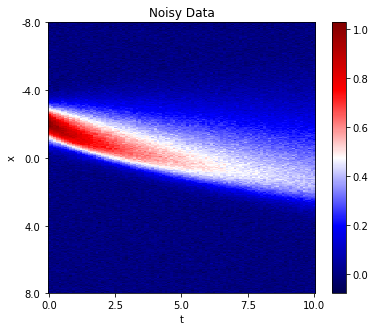

In [3]:
# Add noise
np.random.seed(0)
noise_level = 0.1
u = u.real + noise_level*np.std(u.real)*np.random.randn(u.shape[0],u.shape[1])

im = plt.imshow(u.real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.title("Noisy Data")
plt.xlabel("t")
plt.ylabel("x")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)
plt.gcf().set_size_inches(6,5)
plt.show()

In [4]:
# Prepare Training Data
xx, tt = np.meshgrid(x,t)
X = np.vstack([xx.ravel(), tt.ravel()]).T
print("X shape", X.shape)
print(X)

X shape (25856, 2)
[[-8.      0.    ]
 [-7.9375  0.    ]
 [-7.875   0.    ]
 ...
 [ 7.8125 10.    ]
 [ 7.875  10.    ]
 [ 7.9375 10.    ]]


y shape (25856, 1)


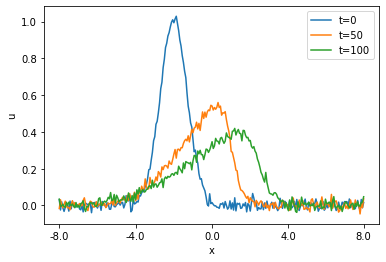

In [5]:
y = np.zeros((u.size, 1), dtype=np.float)
for i,_x in enumerate(u.real.T):
    y[i*len(x):(i+1)*len(x)] = _x.reshape(len(x),1)
    
print("y shape", y.shape)

plt.plot(y[:256], label="t=0")
plt.plot(y[50*256:51*256], label="t=50")
plt.plot(y[100*256:101*256], label="t=100")
plt.xlabel("x")
plt.ylabel("u")
plt.xticks(ypos, ytick)
plt.legend()
plt.show()

X_train shape torch.Size([1000, 2])
y_train shape torch.Size([1000, 1])
X shape (25856, 2)
y shape (25856, 1)


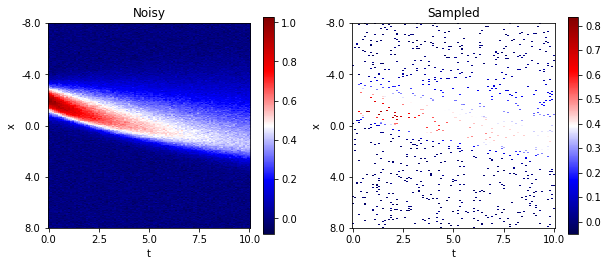

In [6]:
idxs = np.random.choice(y.size, 1000, replace=False)

X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idxs], dtype=torch.float32)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X shape", X.shape)
print("y shape", y.shape)

plt.subplot(1,2,1)
im = plt.imshow(u, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Noisy")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

usamp = np.full(y.shape,np.nan)
usamp[idxs] = y[idxs]
usamp = usamp.reshape(u.T.shape).T

plt.subplot(1,2,2)
im = plt.imshow(usamp, cmap="seismic", aspect=.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Sampled")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.gcf().set_size_inches(10,4)
plt.show()

In [7]:
# Setup Network
net = PINN(sizes=[2,20,15,10,5,1], activation=torch.nn.Tanh())
print(net)

PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Tanh()
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [8]:
#Construct Library
def build_library(data, uhat, poly_order, deriv_order):
    # build polynomials
    poly = torch.ones_like(uhat)
    
    # concatinate different orders
    for o in np.arange(1, poly_order+1):
        poly_o = poly[:,o-1:o]*uhat
        poly = torch.cat((poly, poly_o), dim=1)
        
    # build derivatives
    # returns gradient of uhat w.r.t. data (id0=spatial, id1=temporal)
    du = grad(outputs=uhat, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    
    # time derivative
    dudt = du[:,1:2]
    
    # spatial derivatives
    dudx = torch.cat((torch.ones_like(dudt), du[:,0:1]), dim=1)
    
        # concatinate different orders
    for o in np.arange(1, deriv_order):
        du = grad(outputs=dudx[:,o:o+1], inputs=data, 
                  grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
        dudx = torch.cat((dudx, du[:,0:1]), dim=1)
    
    # build all possible combinations of poly and dudx vectors
    theta = None
    for i in range(poly_order+1):
        for j in range(deriv_order+1):
            comb = poly[:,i:i+1] * dudx[:,j:j+1]
            
            if theta is None:
                theta = comb
            else:
                theta = torch.cat((theta, comb), dim=1)
                
    return dudt, theta

In [9]:
polynm = ['1', 'u', 'uˆ2']
spa_der = ['1', 'u_{x}', 'u_{xx}']
library_coeffs = pde_matrix_mul(polynm, spa_der)
print('library_coeffs:', library_coeffs)

tot_items = len(library_coeffs)
print('tot_items:', tot_items)

epochs = 6000
#xi = nn.Parameter(torch.randn((1, 1), requires_grad=True, device="cpu", dtype=torch.float32))
xi = nn.Parameter(torch.randn((tot_items, 1), requires_grad=True, device="cpu", dtype=torch.float32))
#xi = torch.tensor([[0.1], [-1]])
#print(xi)
#params = [{'params': net.parameters(), 'lr': 1e-3}]
params = [{'params': net.parameters(), 'lr': 3e-3}, {'params': xi, 'lr': 3e-2}]

optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

library_coeffs: ['1', 'u_{x}', 'u_{xx}', 'u', 'uu_{x}', 'uu_{xx}', 'uˆ2', 'uˆ2u_{x}', 'uˆ2u_{xx}']
tot_items: 9


In [10]:
def model_identification(features, label, mask, poly_order, deriv_order):
    lamb   = 0
    tolerance = 1e-5
    mask = torch.ones(tot_items, 1)
    print('xi', xi)
    print('mask:', mask.shape)
    lambd  = 1e-5

    
    for epoch in range(epochs):
        optimizer.zero_grad()
        uhat = net(features)
    
        if epoch == 100:
            lamb = 1
               
        dudt, theta = build_library(features, uhat, poly_order=2, deriv_order=2)
        #print('dudt:', dudt.shape)
        dudt_norm = torch.norm(dudt, dim=0)
        #print('dudt_norm:', dudt_norm.shape)
    
    
        theta_scaling = (torch.norm(theta, dim=0))
        #print('theta_scaling:', theta_scaling.shape)
        #Returns a new tensor with a dimension of size one inserted at the specified position. from 9 it will be 9,1
        theta_norm = torch.unsqueeze(theta_scaling, dim = 1) 
        #print('theta_norm:', theta_norm.shape)
        xi_normalized = xi * (theta_norm / dudt_norm) 
        L1 = lambd * torch.sum(torch.abs(xi_normalized[1:, :]))
        
        l_u   = nn.MSELoss()(uhat, label)
        #l_reg = lamb * torch.mean((dudt - theta @ xi)**2)
        l_reg = torch.mean((dudt - theta @ xi)**2)

        loss = l_u + l_reg + L1
        #print('loss', loss)
    

        
        gradient_loss = torch.max(torch.abs(grad(outputs=loss, inputs=xi, 
              grad_outputs=torch.ones_like(loss), create_graph=True)[0]) / (theta_norm / dudt_norm))
        


        loss.backward(retain_graph=True)
        optimizer.step()
    
        #print("epoch {}/{}, loss={:.10f}".format(epoch+1, epochs, loss.item()), end="\r")
        
        if epoch % 1000 == 0:
            print('loss:', epoch, loss)
            if gradient_loss < tolerance:
                print('Optimizer converged.')
                break
 
    #print('xi_normalized:', xi_normalized)
    xi_list = sparse_coeff(mask, xi.detach().numpy())
    xi_normalized = sparse_coeff(mask, xi_normalized.detach().numpy())
    print('xi_normalized:', xi_normalized)
    
    sparsity = normalized_xi_threshold( xi_normalized, mode='auto')
    print('sparsity:', sparsity)
    
  
    xi_thresholded = np.expand_dims(xi_list[sparsity], axis=1) 
    print('xi_thresholded:', xi_thresholded)
    # Printing current sparse vector 
    print('Coefficient xi:')
    xi_updated = sparse_coeff(sparsity, xi_thresholded)
    print(xi_updated)
    print('Finished')
            
            
    return xi_updated


In [11]:
mask = torch.ones(tot_items, 1)
uhat = net(X_train)
xi_updated= model_identification(X_train, y_train, mask, poly_order=2, deriv_order=2)

xi Parameter containing:
tensor([[-1.6925],
        [-0.1796],
        [-0.7701],
        [-0.9402],
        [-0.0480],
        [-0.4378],
        [ 0.4478],
        [-0.6831],
        [ 1.0623]], requires_grad=True)
mask: torch.Size([9, 1])
loss: 0 tensor(2.7576, grad_fn=<AddBackward0>)
loss: 1000 tensor(0.0013, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0009, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0006, grad_fn=<AddBackward0>)
loss: 4000 tensor(0.0004, grad_fn=<AddBackward0>)
loss: 5000 tensor(0.0004, grad_fn=<AddBackward0>)
xi_normalized: [[ 1.11704962e-02]
 [-1.17986254e-01]
 [ 4.22208548e-01]
 [-1.12952413e-02]
 [-9.07323718e-01]
 [-5.40276757e-03]
 [-3.31132498e-04]
 [ 2.03889897e-04]
 [-7.59159494e-03]]
sparsity: [[False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]]
xi_thresholded: [[ 0.09697793]
 [-0.86513686]]
Coefficient xi:
[[ 0.        ]
 [ 0.        ]
 [ 0.09697793]
 [ 0.        ]
 [-0.86513686]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]

In [12]:
print(uhat.shape)
pde_Recover(xi_updated, library_coeffs, equation_form='u_t')

torch.Size([1000, 1])
Burger equation:


'u_t = 0.0970u_{xx} - 0.8651uu_{x}'

uhat.shape: torch.Size([25856, 1])
MSE loss 0.0003483209584373981


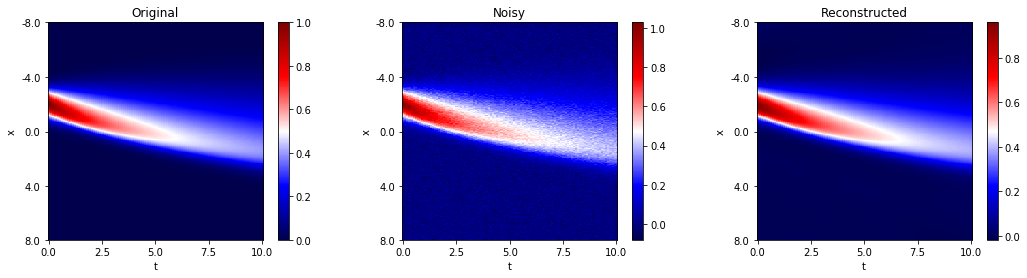

In [13]:
uhat = net(torch.FloatTensor(X))
print('uhat.shape:', uhat.shape)
print("MSE loss", nn.MSELoss()(uhat, torch.FloatTensor(y)).item())

uhat = uhat.data.reshape(u.T.shape)

plt.subplot(1,3,1)
im = plt.imshow(data["usol"].real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Original")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.subplot(1,3,2)
im = plt.imshow(u, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Noisy")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.subplot(1,3,3)
im = plt.imshow(uhat.numpy().T, cmap="seismic", aspect=.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Reconstructed")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.gcf().set_size_inches(18,4)
plt.show()


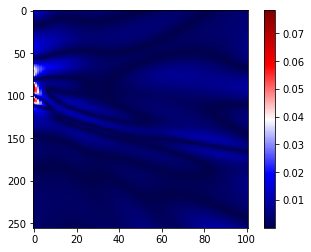

In [14]:
plt.imshow(np.abs(uhat.numpy().T.data - data["usol"].real), cmap="seismic", aspect=.4)
plt.colorbar()
plt.show()